# A Large Dimenional Analysis of LS-SVM

by [Zhenyu Liao](http://zhenyu-liao.github.io/), CentraleSupelec, Paris-Saclay

In [1]:
import scipy.special,scipy.linalg
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_mldata

### Get Data (MNIST dataset or Mixture Gaussian)

In [2]:
def get_data(testcase,n,n_test,prop,selected_target=None,means=None,covs=None,):
    rng = np.random

    # different cases for data
    if testcase is 'MNIST':
        mnist=fetch_mldata('MNIST original')
        X,y = mnist.data,mnist.target
        X_train_full, X_test_full = X[:60000], X[60000:]
        y_train_full, y_test_full = y[:60000], y[60000:]

        p = 784
        K=len(selected_target)
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)        
        
        y_train = []
        y_test = []
        ind=0
        for i in selected_target:
            locate_target_train = np.where(y_train_full==i)[0][range(np.int(prop[ind]*n))]
            locate_target_test  = np.where(y_test_full==i)[0][range(np.int(prop[ind]*n_test))]
            X_train = np.concatenate( (X_train,X_train_full[locate_target_train].T),axis=1)
            y_train = np.concatenate( (y_train,2*(ind-K/2+.5)*np.ones(np.int(n*prop[ind]))) )
            X_test  = np.concatenate( (X_test,X_test_full[locate_target_test].T),axis=1)
            y_test = np.concatenate( (y_test,2*(ind-K/2+.5)*np.ones(np.int(n_test*prop[ind]))) )
            ind+=1                       
        
        X_train = X_train - np.mean(X_train,axis=1).reshape(p,1)
        X_train = X_train*np.sqrt(784)/np.sqrt(np.sum(X_train**2,(0,1))/n)
        
        X_test = X_test - np.mean(X_test,axis=1).reshape(p,1)
        X_test = X_test*np.sqrt(784)/np.sqrt(np.sum(X_test**2,(0,1))/n_test)
        
    else:
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)       
        y_train = []
        y_test = []
        K = len(prop)
        for i in range(K):            
            X_train = np.concatenate((X_train,rng.multivariate_normal(means[i],covs[i],size=np.int(n*prop[i])).T),axis=1)
            X_test  = np.concatenate((X_test, rng.multivariate_normal(means[i],covs[i],size=np.int(n_test*prop[i])).T),axis=1)
            y_train = np.concatenate( (y_train,2*(i-K/2+.5)*np.ones(np.int(n*prop[i]))) )
            y_test = np.concatenate( (y_test,2*(i-K/2+.5)*np.ones(np.int(n_test*prop[i]))) )            
            
    #X_train = X_train/np.sqrt(p)
    #X_test  = X_test/np.sqrt(p)
            
    return X_train, X_test, y_train, y_test

### Generate Kernel function $f$

In [3]:
def get_kernel(kernel,z,derivs=None,tau=None,sigma2=None):
    if kernel in ['poly','poly_zero']:
        if derivs is None:
            print('Error: Try to use poly kernel: please give derivatives!\n')
        else:
            coeffs = np.zeros(3)
            for i in range(3):
                coeffs[i] = derivs[2-i]/np.math.factorial(2-i)
            f = np.polyval(coeffs,(z-tau))
    elif kernel is 'gauss':
        if sigma2 is None:
            print('Error: Try to use Gaussian kernel: please give sigma2!\n')
        else:
            f = np.exp(-z/(2*sigma2))
        
    return f

### Get statistics of MNIST data

In [4]:
def get_stat(X,prop):
    p = X_train.shape[0]
    n = X_train.shape[1]
    k = len(prop)
    
    index = []
    means = []
    covs = []
    tmp = 0
    for i in range(k):
        index.append(np.arange(tmp,tmp+int(n*prop[i]),1))
        means.append(np.mean(X_train[:,index[i]],axis=1).reshape(p,1))
        covs.append((X_train[:,index[i]]@X_train[:,index[i]].T/(n*prop[i]) - means[i]@(means[i].T)).reshape(p,p))
        tmp = tmp+int(n*prop[i])-1
    
    return means,covs

## Main code

In [5]:
testcase = 'MNIST'# testcase for simulation, among 'iid','means','var','orth','mixed','MNIST'
kernel = 'gauss'  # kernel used for LS-SVM, among 'gauss', 'poly', 'poly_zero'

n = 256 # number of training samples 
n_test = 1024 # number of test simples
p = 128 # dimension of data
prop = [.25,.75] # two-class problem
k = len(prop)

gamma = 1


loops = 50        # Number of generations of W to be averaged over

g=np.zeros((loops,n_test))

rng = np.random
for loop in range(loops):    
    
    ## Generate X_train,X_test,y_train,y_test
    if testcase is 'MNIST':
        p=784
        selected_target = [3,8]
        X_train,X_test,y_train,y_test = get_data(testcase,n,n_test,prop,selected_target)
    else:    
        means=[]
        covs=[]
        if testcase is 'iid':
            for i in range(k):
                means.append(np.zeros(p))
                covs.append(np.eye(p))     
        elif testcase is 'means':
            for i in range(k):
                means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
                covs.append(np.eye(p))
        elif testcase is 'var':
            for i in range(k):
                means.append(np.zeros(p))
                covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
        elif testcase is 'orth':
            for i in range(k):
                means.append(np.zeros(p))
                covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),4*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
        elif testcase is 'mixed':
            for i in range(k):
                means.append( np.concatenate( (np.zeros(i),2*np.ones(1),np.zeros(p-i-1)) ) )
                covs.append((1+4*i/np.sqrt(p))*scipy.linalg.toeplitz( [(.4*i)**x for x in range(p)] ))            

        X_train,X_test,y_train,y_test = get_data(testcase,n,n_test,prop,means,covs)

    # computation of tau
    XX_train = X_train.T@X_train/p
    XX_test = X_test.T@X_test/p
    tau = 2*np.trace(XX_train)/n

    
    # Build kernel matrix K
    if kernel is 'gauss':
        sigma2 = 1
        derivs = None
    elif kernel is 'poly':
        sigma2 = None
        derivs = [3, -.5, 2]
    elif kernel is 'poly_zero':
        sigma2 = None
        derivs = [3, 0, 2]
    
    K = get_kernel(kernel, XX_train.diagonal(offset=0).reshape(n,1)@np.ones(n).reshape(1,n)+np.ones(n).reshape(n,1)@XX_train.diagonal(offset=0).T.reshape(1,n)-2*XX_train, derivs, tau, sigma2)

    S = K + n/gamma*np.eye(n)
    invS_y = scipy.linalg.solve(S,y_train)
    invS_1 = scipy.linalg.solve(S,np.ones(n))

    b = invS_y.sum()/invS_1.sum()
    alpha = invS_y - invS_1*b
    g[loop,:] = alpha.T@get_kernel(kernel, XX_train.diagonal(offset=0).reshape(n,1)@(np.ones(n_test).reshape(1,n_test))+np.ones(n).reshape(n,1)@XX_test.diagonal(offset=0).reshape(1,n_test)-2*X_train.T@X_test/p, derivs, tau, sigma2)+b
    
    # if we remove b
    # alpha = invS_y
    # g[idx] = alpha.T@get_kernel(kernel, XX_train.diagonal(offset=0).reshape(n,1)@(np.ones(n_test).reshape(1,n_test))+np.ones(n).reshape(n,1)@XX_test.diagonal(offset=0).reshape(1,n_test)-2*X_train.T@X_test/p, derivs, tau, sigma2)
    
# Computation for theoritical means and var
if kernel is 'gauss':
    f_tau = get_kernel(kernel,tau,derivs,tau,sigma2)
    derivs = [f_tau, -f_tau/(2*sigma2), f_tau/(4*sigma2**2)]
    
if testcase is 'MNIST':
    means,covs = get_stat(X_train,prop)


t1 = np.trace(covs[0]-prop[0]*covs[0]-prop[1]*covs[1])/np.sqrt(p)
t2 = np.trace(covs[1]-prop[0]*covs[0]-prop[1]*covs[1])/np.sqrt(p)
    
D = -2*derivs[1]*(np.linalg.norm(means[1]-means[0]))**2/p + derivs[2]*(t1-t2)**2/p + 2*derivs[2]*(np.trace((covs[0]-covs[1])**2))/(p**2)

mean_th = (prop[1]-prop[0])*np.array([1.0,1.0])+2*prop[0]*prop[1]*gamma*D*np.array([-prop[1],prop[0]])
V11 = (t2-t1)**2*derivs[2]**2*np.trace(covs[0]**2)/(p**3)
V12 = (t2-t1)**2*derivs[2]**2*np.trace(covs[1]**2)/(p**3)
V21 = 2*derivs[1]**2*(means[1]-means[0]).T@covs[0]@(means[1]-means[0])/(p**2)
V22 = 2*derivs[1]**2*(means[1]-means[0]).T@covs[1]@(means[1]-means[0])/(p**2)
V31 = 2*derivs[1]**2*(np.trace(covs[0]**2)/prop[0]+np.trace(covs[0]*covs[1])/prop[1])/(n*p**2)
V32 = 2*derivs[1]**2*(np.trace(covs[0]*covs[1])/prop[0]+np.trace(covs[1]**2)/prop[1])/(n*p**2)
var_th = 8*gamma**2*(prop[0]*prop[1])**2*np.array([V11+V21+V31, V12+V22+V32])


### Plots

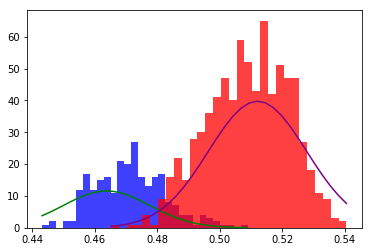

In [6]:
g_mean = np.mean(g,0)
    
g1 = g_mean[range(int(n_test*prop[0]))]
g2 = g_mean[int(n_test*prop[0]):]

xs1 = np.linspace(min(g1.flatten()),max(g1.flatten()),30)
xs2 = np.linspace(min(g2.flatten()),max(g2.flatten()),30)
step1 = xs1[1]-xs1[0]
step2 = xs2[1]-xs2[0]
g_th1 = scipy.stats.norm.pdf((xs1-mean_th[0])/np.sqrt(var_th[0])).reshape(30,1)
g_th2 = scipy.stats.norm.pdf((xs2-mean_th[1])/np.sqrt(var_th[1])).reshape(30,1)

n1, bins1, patches1 ,= plt.hist(g1.flatten(), 30, facecolor='blue', alpha=0.75)
n2, bins2, patches2 ,= plt.hist(g2.flatten(), 30, facecolor='red', alpha=0.75)

pl1 ,=plt.plot(xs1,g_th1*n_test*loops*prop[0]*step1,'green')
pl2 ,=plt.plot(xs2,g_th2*n_test*loops*prop[1]*step2,'purple')
plt.show()